### EfficientNet-B7

The EfficientNet is a pretrained CNN model, we use it to predict images

In [1]:
# Using GPU to train CNN
!nvidia-smi

Sat Jun 06 00:21:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 445.87       Driver Version: 445.87       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:01:00.0  On |                  N/A |
| 13%   55C    P0    66W / 260W |    519MiB / 11264MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
import pandas as pd
import os
import cv2
import numpy as np

import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Check whether using GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# Read dataset
Train=pd.read_csv('plant-pathology-2020-fgvc7/train.csv')
Test=pd.read_csv('plant-pathology-2020-fgvc7/test.csv')

In [5]:
# Resizing images
img_size=100
Train_image=[]
for name in Train['image_id']:
    path='plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    Train_image.append(image)

Test_image=[]
for name in Test['image_id']:
    path='plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    Test_image.append(image)

In [6]:
# Vectorizing the channels - image to array
X_train = np.ndarray(shape=(len(Train_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in Train_image:
    X_train[i]=img_to_array(image)
    X_train[i]=Train_image[i]
    i=i+1
X_train=X_train/255
print('Train Shape: {}'.format(X_train.shape))

X_test = np.ndarray(shape=(len(Test_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in Test_image:
    X_test[i]=img_to_array(image)
    X_test[i]=Test_image[i]
    i=i+1
    
X_test=X_test/255
print('Test Shape: {}'.format(X_test.shape))

Train Shape: (1821, 100, 100, 3)
Test Shape: (1821, 100, 100, 3)


In [7]:
# Deal with labels
Y = Train.copy()
del Y['image_id']
Y.head()
Y_train = np.array(Y.values)
Y_train.shape

(1821, 4)

In [8]:
# We split the training set into training and testing set
train_x,test_x,train_y,test_y = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [9]:
# Dealing with imbalanced dataset - oversampling
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 0) 
 
train_x,train_y = sm.fit_resample(train_x.reshape((-1, img_size * img_size * 3)), train_y)
train_x = train_x.reshape((-1, img_size, img_size, 3))
train_x.shape, train_y.sum(axis=0)

((1960, 100, 100, 3), array([490, 490, 490, 490]))

In [10]:
# Image augmentation
data_aug = ImageDataGenerator(rotation_range=45,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              shear_range=0.2,
                              rescale=1/255,
                              brightness_range=[0.5,1.5],
                              horizontal_flip=True,
                              vertical_flip=True)

In [11]:
# Using EfficientNet-B7 model
base_model = efn.EfficientNetB7(input_shape=(100,100,3),weights='imagenet',include_top=False)
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 4, 4, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________


In [12]:
# Start to train model
model.fit_generator(data_aug.flow(train_x,train_y,batch_size=32),
                    steps_per_epoch=train_x.shape[0]//32,
                    epochs=100,
                    verbose=1,
                    validation_data=(test_x,test_y),
                    use_multiprocessing=False,
                    workers=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
61/61 [==============================] - 21s 337ms/step - loss: 1.4089 - accuracy: 0.4201 - val_loss: 2.1502 - val_accuracy: 0.4219
Epoch 2/100
61/61 [==============================] - 15s 251ms/step - loss: 0.8275 - accuracy: 0.6966 - val_loss: 1.3121 - val_accuracy: 0.6027
Epoch 3/100
61/61 [==============================] - 15s 252ms/step - loss: 0.5405 - accuracy: 0.8294 - val_loss: 1.7182 - val_accuracy: 0.6192
Epoch 4/100
61/61 [==============================] - 15s 253ms/step - loss: 0.4861 - accuracy: 0.8402 - val_loss: 0.3549 - val_accuracy: 0.8986
Epoch 5/100
61/61 [==============================] - 15s 254ms/step - loss: 0.3990 - accuracy: 0.8574 - val_loss: 0.8162 - val_accuracy: 0.8055
Epoch 6/100
61/61 [==============================] - 15s 251ms/step - loss: 0.3911 - accuracy: 0.8672 - val_loss: 0.3309 - val_accuracy: 0.8986
Epoch 7/100
61/61 [==============================] - 15s 252

Epoch 56/100
61/61 [==============================] - 15s 252ms/step - loss: 0.1051 - accuracy: 0.9647 - val_loss: 0.4756 - val_accuracy: 0.8849
Epoch 57/100
61/61 [==============================] - 15s 253ms/step - loss: 0.1003 - accuracy: 0.9673 - val_loss: 0.3084 - val_accuracy: 0.9397
Epoch 58/100
61/61 [==============================] - 15s 254ms/step - loss: 0.0679 - accuracy: 0.9777 - val_loss: 0.2604 - val_accuracy: 0.9342
Epoch 59/100
61/61 [==============================] - 15s 252ms/step - loss: 0.0906 - accuracy: 0.9694 - val_loss: 0.2505 - val_accuracy: 0.9315
Epoch 60/100
61/61 [==============================] - 15s 251ms/step - loss: 0.0896 - accuracy: 0.9730 - val_loss: 0.3289 - val_accuracy: 0.9452
Epoch 61/100
61/61 [==============================] - 15s 253ms/step - loss: 0.0779 - accuracy: 0.9767 - val_loss: 0.4184 - val_accuracy: 0.9315
Epoch 62/100
61/61 [==============================] - 15s 252ms/step - loss: 0.0906 - accuracy: 0.9725 - val_loss: 0.3306 - val_ac

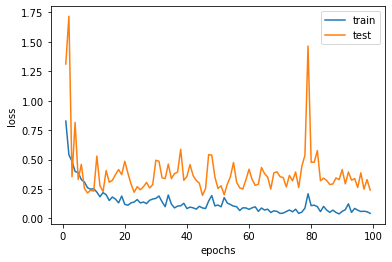

In [13]:
# Plot loss
history = model.history.history
offset = 1
epochs = range(offset, len(history['loss']))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, history['loss'][offset:], label='train')
plt.plot(epochs, history['val_loss'][offset:], label='test')
plt.legend()

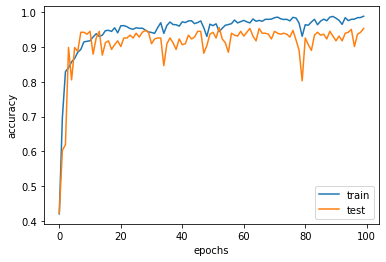

In [14]:
# plot accuracy
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history[f'accuracy'], label='train')
plt.plot(history[f'val_accuracy'], label='test')
plt.legend()

In [15]:
Y1 = Test.copy()
del Y1['image_id']
Y1.head()
Y_test = np.array(Y1.values)
Y_test.shape

(1821, 0)

In [16]:
# predict on the testing set
predict_prob = model.predict(X_test)
df_predict_prob = pd.DataFrame(predict_prob, columns=['healthy','multiple_diseases','rust','scab'])

In [17]:
# output csv files for submission
frame = [Test['image_id'], df_predict_prob]
df_submission = pd.concat(frame, axis=1)
df_submission.to_csv(r'submisson.csv', index=False)